# Policy Gradient Methods

In [ ]:
from IPython.lib.display import YouTubeVideo

### The Big Picture

In [ ]:
YouTubeVideo('zoOgRoaxGiU')

### Connections to Supervised Learning

In [ ]:
YouTubeVideo('dJz_p4FKE-g')

To further explore the connections between policy gradient methods and supervised learning, check out Andrej Karpathy's [famous blog post](http://karpathy.github.io/2016/05/31/rl/).

### Problem Setup

Let's rigorously define how policy gradient methods work.

In [ ]:
YouTubeVideo('St9ftvMQ_ks')

The equation $U(\theta)=\displaystyle\sum_\tau\mathbb{P}(\tau;\theta)R(\tau)$ corresponds to the expected return, note that we've expressed the return $R(\tau)$ as a function of the trajectory $\tau$. Then, we calculate the weighted average (where the weights are given by $\mathbb{P}(\tau;\theta)$) of all possible values that the return $R(\tau)$ can take.

#### Why Trajectories !!

We're using trajectories instead of episodes because maximizing expected return over trajectories (instead of episodes) lets us search for optimal policies for both episodic and continuing tasks!

However, for many episodic tasks, it often makes sense to just use the full episode. In particular, for the case of the video game example described in the videos, reward is only delivered at the end of the episode. In this case, in order to estimate the expected return, the trajectory should correspond to the full episode; otherwise, we don't have enough reward information to meaningfully estimate the expected return.

## REINFORCE

Our goal is to find the values of the weights $\theta$ in the neural network that maximize the expected return $U(\theta)=\displaystyle\sum_\tau P(\tau;\theta)R(\tau)$, where $\tau$ is an arbitrary trajectory. One way to determine the value of $\theta$ that maximizes this function is through gradient ascent, where the update step appears as follows:

$$\theta\leftarrow\theta+\alpha\nabla_\theta$$

where $\alpha$ is the step size that is generally allowed to decay over time. Once we know how to calculate or estimate this gradient, we can repeatedly apply this update step, in the hopes that $\theta$ converges to the value that maximizes $U(\theta)$.

In [ ]:
YouTubeVideo('o6CI2q3IXEs')

### Pseudocode
The algorithm described in the video is known as **REINFORCE**. The pseudocode is summarized below.

1. Use the policy $\pi_\theta$ to collect $m$ trajectories $\left\{\tau^{(1)},\tau^{(2)},\ldots,\tau^{(m)}\right\}$ with planning horizon $H$. We refer to the $i^{th}$ trajectory as $$\tau^{(i)} = \left(s_0^{(i)}, a_0^{(i)}, \ldots, s_H^{(i)}, a_H^{(i)}, s_{H+1}^{(i)}\right)$$

2. Use the trajectories to estimate the gradient $\nabla_\theta U(\theta)$: $$\nabla_\theta U(\theta) \approx \hat{g} := \frac{1}{m}\sum_{i=1}^m\sum_{t=0}^{H}\nabla_\theta\log\pi_\theta\left(a_t^{(i)}|s_t^{(i)}\right)R\left(\tau^{(i)}\right)$$

3. Update the weights of the policy: $\theta\leftarrow\theta+\alpha\hat{g}$

4. Loop over steps 1-3

### Derivation

The derivation of the equation that is used to approximate the gradient is described below.

#### Likelihood Ratio Policy Gradient

We'll begin by exploring how to calculate the gradient $\nabla_\theta U(\theta)$. The calculation proceeds as follows:

\begin{aligned}
  \nabla_\theta U(\theta) &= \nabla_\theta \sum_\tau P(\tau;\theta)R(\tau) &\\
                          &= \sum_\tau \nabla_\theta P(\tau;\theta)R(\tau) &\\
                          &= \sum_\tau \frac{P(\tau;\theta)}{P(\tau;\theta)} \nabla_\theta P(\tau;\theta)R(\tau) & (1)\\
                          &= \sum_\tau P(\tau;\theta) \frac{\nabla_\theta P(\tau;\theta)}{P(\tau;\theta)}R(\tau) &\\
                          &= \sum_\tau P(\tau;\theta)\left[\nabla_\theta \log P(\tau;\theta) R(\tau)\right] &\\
                          &= \mathbb{E}_{\tau\sim\pi_\theta}\left[\nabla_\theta\log P(\tau;\theta)R(\tau)\right] &
\end{aligned}

The _trick_ in equation (1) is referred to as the **likelihood ratio trick** or **REINFORCE trick**.

Likewise, it is common to refer to the gradient as the **likelihood ratio policy gradient**: $\nabla_\theta U(\theta) = \mathbb{E}_{\tau\sim\pi_\theta}\left[\nabla_\theta\log P(\tau;\theta)R(\tau)\right]$

Once we’ve written the gradient as an expected value in this way, it becomes much easier to estimate.

#### Sample-Based Estimate

We can approximate the likelihood ratio policy gradient with a sample-based average, as follows:

$$\nabla_\theta U(\theta)\approx\frac{1}{m}\sum_{i=1}^m\nabla_\theta\log P\left(\tau^{(i)};\theta\right)R\left(\tau^{(i)}\right)$$
where each $\tau^{(i)}$ is a sampled trajectory.

We will further simplify $\nabla_\theta\log P\left(\tau^{(i)};\theta\right)$ as follows:
\begin{aligned}
    \nabla_\theta\log P\left(\tau^{(i)};\theta\right) &= \nabla_\theta\log\left[\prod_{t=0}^{H}P\left(s_{t+1}^{(i)}|s_{t}^{(i)},a_t^{(i)}\right)\pi_\theta\left(a_t^{(i)}|s_t^{(i)}\right)\right]\\
                                                              &= \nabla_\theta\left[\sum_{t=0}^{H}\log P\left(s_{t+1}^{(i)}|s_{t}^{(i)},a_t^{(i)}\right)+\sum_{t=0}^{H}\log\pi_\theta\left(a_t^{(i)}|s_t^{(i)}\right)\right]\\
                                                              &= \nabla_\theta\sum_{t=0}^{H}\log P\left(s_{t+1}^{(i)}|s_{t}^{(i)},a_t^{(i)}\right)+\nabla_\theta\sum_{t=0}^{H}\log\pi_\theta\left(a_t^{(i)}|s_t^{(i)}\right)\\
                                                              &= \nabla_\theta\sum_{t=0}^{H}\log\pi_\theta\left(a_t^{(i)}|s_t^{(i)}\right)\\
                                                              &= \sum_{t=0}^{H}\nabla_\theta\log\pi_\theta\left(a_t^{(i)}|s_t^{(i)}\right)
\end{aligned}

and obtain our final estimation $$\nabla_\theta U(\theta)\approx\frac{1}{m}\sum_{i=1}^m\sum_{t=0}^{H}\nabla_\theta\log\pi_\theta\left(a_t^{(i)}|s_t^{(i)}\right)R\left(\tau^{(i)}\right)$$

---

#### An Example
Suppose we are training an agent to play a computer game. There are only two possible action:
```
   0 = Do nothing
   1 = Move
```

There are three time-steps in each game, and our policy is completely determined by one parameter $\theta$, such that the action probabilities are defined as follows:

$\begin{align}
Pr(\text{moving})=\pi_\theta(1∣\cdot)&=\theta\\
Pr(\text{doing nothing})=\pi_\theta(0∣\cdot)&=1-\theta
\end{align}
$

Initially $\theta=0.5$. Three games are played, the results are:
```
Game 1: actions: (1,0,1) rewards: (1,0,1)
Game 2: actions: (1,0,0) rewards: (0,0,1)
Game 3: actions: (0,1,0) rewards: (1,0,1)
```
Q1. What are the future rewards for the first game?
 - [ ] (1,0,1)
 - [ ] (1,0,2)
 - [ ] (2,0,1)
 - [x] (2,1,1)
 - [ ] (1,1,2)
 
Q2. What is the policy gradient computed from the second game, using future rewards?
 - [x] -2
 - [ ] -1
 - [ ] 0
 - [ ] 1
 - [ ] 2
 
Q3. Which of these statements are true regarding the 3rd game?
 - [ ] We can add a baseline -1 point to the rewards, the computed gradient wouldn't change
 - [x] The contribution to the gradient from the second and third steps cancel each other
 - [ ] The computed policy gradient from this game is 0
 - [x] The computed policy gradient from this game is negative
 - [x] Using the total reward vs future reward give the same policy gradient in this game
 
---

Next we will train REINFORCE with OpenAI Gym's Cartpole environment.

### Import the Necessary Packages

In [ ]:
import time
import os.path
import numpy as np
import random as rand
from collections import deque

import gym
gym.logger.set_level(40)                    # suppress warnings (please remove if gives error)

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

from utils.ParallelEnvironments import ParallelEnv

from IPython.display import display as Display
from IPython.display import HTML
from pyvirtualdisplay import Display as display
display = display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
ENVIRONMENT = 'CartPole-v0'
MODEL_FILE = './models/reinforce-cart-pole.pt'
RANDOM_SEED = 5

### Train the Agent with REINFORCE

In [ ]:
env = gym.make(ENVIRONMENT)

env.seed(RANDOM_SEED)
rand.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print('observation space:', env.observation_space)
print('action space:', env.action_space)

### Define the Architecture of the Policy

In [ ]:
class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        '''
        computes 𝜋(action|state)
        
        Params
        ======
            states: state vector of shape (1, 4)
                    example: [-0.04456399  0.04653909  0.01326909 -0.02099827]
        '''
        state = torch.from_numpy(state).float().unsqueeze(0).to(device) # tensor([[-0.0445 0.0465 0.0132 -0.0209]])
        probs = self.forward(state).to(device)                          # tensor([[0.410 0.589]])
        
        m = Categorical(probs)          # https://pytorch.org/docs/stable/distributions.html
        action = m.sample()             # tensor([1])
        log_prob = m.log_prob(action)   # tensor([-0.528])
        action = action.item()          # 1

        return action, log_prob

In [ ]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

### The REINFORCE Algorithm

In [ ]:
LOG_EVERY = 100
TARGET_SCORE = 195.0

In [ ]:
def reinforce(n_episodes=1000, max_t=1000, gamma=1.0):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 

        scores.append(sum(rewards))
        scores_deque.append(scores[-1])
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)

        # policy_loss == [tensor([9.5131]), ... , tensor([16.9835])]
        policy_loss = torch.cat(policy_loss).sum()
        # policy_loss == tensor(209.5441)
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        print('\rEpisode {:04d}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, np.mean(scores_deque), scores[-1]), end='')
        if i_episode % LOG_EVERY == 0:
            print('\r{}'.format(' ' * 120), end='')
            print('\rEpisode {:04d}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= TARGET_SCORE:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(policy.state_dict(), MODEL_FILE)
            break
        
    return scores

#### The Training Loop

In [ ]:
scores = reinforce(n_episodes=2000)

### Plot the Scores

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Watch a Smart Agent!

In [ ]:
env = gym.make(ENVIRONMENT)
policy = Policy().to(device)

# load the weights from file
map_location = (lambda storage, loc: storage.cuda()) if torch.cuda.is_available() else 'cpu'
policy.load_state_dict(torch.load(MODEL_FILE, map_location=map_location))

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action, _ = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break

In [ ]:
env.close()

REINFORCE can also be used to solve environments with continuous action spaces. For an environment with a continuous action space, the corresponding policy network could have an output layer that parametrizes a continuous probability distribution.

For instance, assume the output layer returns the mean $\mu$ and variance $\sigma^2$ of a normal distribution. Then in order to select an action, the agent needs only to pass the most recent state $s_t$s as input to the network, and then use the output mean $\mu$ and variance $\sigma^2$ to sample from the distribution $a_t\sim\mathcal{N}(\mu,\sigma^2)$.

This should work in theory, but it's unlikely to perform well in practice! To improve performance with continuous action spaces, we'll have to make some small modifications to the REINFORCE algorithm.

---
## PPO

### Issues with REINFORCE

In practise we often collect **a single trajectory** $\tau$ to an estimate of the gradient of the expected reward $\nabla_\theta U(\theta)$.

There are three main issues with this approach:

##### The gradient estimate $\nabla_\theta U(\theta)$ is very noisy. By chance the collected trajectory may not be representative of the policy.

In [ ]:
YouTubeVideo('GCGqT2knFJ0')

##### There is no clear credit assignment. A trajectory may contain many good/bad actions and whether these actions are reinforced depends only on the final total output.

In [ ]:
YouTubeVideo('tfZw1moB25Y')

Why does changing the gradient not change the original goal of maximizing the expected reward?

> It turns out that mathematically, ignoring past rewards might change the gradient for each specific trajectory, but it doesn't change the average gradient in an expected sense. So even though the gradient is different during training, on average we are still maximizing the average reward. In fact, the resultant gradient is less noisy, so training using future reward should speed things up!

Next, we will go over ways to improve the REINFORCE algorithm and resolve all 3 issues. The solutions will lead us to [PPO](https://arxiv.org/abs/1707.06347), the idea of which was published by the team at OpenAI.

###### Importance Sampling

In [ ]:
YouTubeVideo('oHE7u15n7Qg', start=36)

\begin{align*}
\mathbb{E}_{x\sim P(x)}{\large[}f(x){\large]}&=\int p(x)f(x)dx\\
                                             &=\int\frac{q(x)}{q(x)}p(x)f(x)dx\\
                                             &=\int q(x)\left(\frac{p(x)}{q(x)}f(x)\right)dx\\
                                             &=\mathbb{E}_{x\sim Q(x)}\left[\frac{p(x)}{q(x)}f(x)\right]
\end{align*}

##### The update process is very inefficient! We run the policy once, update once, and then throw away the trajectory.

In [ ]:
YouTubeVideo('cYPvWriOPIk')

In [ ]:
YouTubeVideo('Y-boYZlpO7g')

In [ ]:
YouTubeVideo('NRzjGGX6c34')

In [ ]:
YouTubeVideo('qRAUAAWA_kc')

The details of PPO was originally published by the team at OpenAI, and their paper is available [here](https://arxiv.org/abs/1707.06347).

## Learning to play Pong using REINFORCE and PPO

Now, we will implement and train a policy to play [atari-pong](https://www.endtoend.ai/envs/gym/atari/#variants), using only the pixels as input. We'll use convolutional neural nets and multiprocessing to implement and train our policy.

Watch the [REINFORCE video](https://www.youtube.com/watch?v=eKIjPrQWIgg) and [PPO video](https://www.youtube.com/watch?v=XhfhR7Z01S0) for a detailed code walk-through.

In [ ]:
ENVIRONMENT          = 'PongDeterministic-v4'
RIGHT                = 4
LEFT                 = 5

REINFORCE_MODEL_FILE = './models/reinforce-pong.pt'
PPO_MODEL_FILE       = './models/ppo-pong.pt'

RANDOM_SEED          = 12345

PongDeterministic does not contain random frameskip, so it's faster to train than the vanilla Pong-v4 environment. More on the different variants of atari enviroments can be found [here](https://www.endtoend.ai/envs/gym/atari/#variants).

In [ ]:
env = gym.make(ENVIRONMENT)

env.seed(RANDOM_SEED)
rand.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print('List of available actions: ', env.unwrapped.get_action_meanings())

We will only use the actions:
```
RIGHTFIRE = 4
LEFTFIRE  = 5
```
The `FIRE` part ensures that the game starts again after losing a life. The actions are hard-coded above.

### Preprocessing

To speed up training, we can simplify the input by cropping the images and use every other pixel

In [ ]:
def preprocess_single(image, bkg_color = np.array([144, 72, 17])):
    '''
    preprocess a single frame (210x160x3)
    crop image and downsample to 80x80
    stack two frames together as input
    '''
    img = np.mean(image[34:-16:2,::2]-bkg_color, axis=-1) / 255.0
    return img

def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    '''
    convert outputs of parallelEnv to inputs of pytorch neural net
    this is useful for batch processing especially on the GPU
    '''
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract background and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color, axis=-1) / 255.0
    batch_input = np.swapaxes(list_of_images_prepro, 0, 1)
    # torch.Size([N, len(images), 80, 80]) i.e. (#data_points, #frames, 80, 80)
    return torch.from_numpy(batch_input).float().to(device)

#### This is what a preprocessed image looks like

In [ ]:
env.reset()
env.step(0)
for _ in range(20): # get a frame after 20 steps
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80x80 black and white image
plt.imshow(preprocess_single(frame), cmap='Greys')
plt.show()

### Policy
 
Now, we define the policy. The input is the stack of two different frames (which captures the movement), and the output is a number $\Pr(right)$, the probability of moving left. Note that $\quad\Pr(left)= 1-\Pr(right)$

In [ ]:
class Policy(nn.Module):
    '''
    set up a convolutional neural net
    
    Params
    ======
        input: Nx2x80x80 shaped vector i.e. N data/input, 2 frames/channels, each image is 80x80
        outout: Nx1 shaped vector representing the probabilities of moving right i.e. P(right)
                P(left) = 1 - P(right)
        N = 1
    '''
    def __init__(self):
        super(Policy, self).__init__()
        # in_channel = number of channels in the input image
        # out_channel = number of channels in the output feature map = number of filters
        # outputsize = (inputsize - kernel_size + stride) / stride  (round up if not an integer)
        # 2x80x80 to 4x38x38
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 4x38x38 to 16x9x9
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=16*9*9
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        # Sigmoid 
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        # shape of x is 1x2x80x80 i.e. 1 data/input, 2 frames/channels, each image is 80x80
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size) # flatten the tensor
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))
    

class BadPolicy(nn.Module):
    def __init__(self):
        super(BadPolicy, self).__init__()
        # 2x80x80 to 1x20x20
        self.conv = nn.Conv2d(2, 1, kernel_size=4, stride=4)
        self.size=1*20*20
        
        # 1 fully connected layer
        self.fc = nn.Linear(self.size, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):    
        x = F.relu(self.conv(x))
        x = x.view(-1,self.size)
        return self.sig(self.fc(x))

In [ ]:
policy = Policy().to(device)

### Game visualization

Here we define a function that plays a game and shows learning progress.

In [ ]:
def animate_frames(frames):
    'function to animate a list of frames'
    
    def display_animation(anim):
        plt.close(anim._fig)
        return HTML(anim.to_jshtml())

    plt.axis('off')
    cmap = None if len(frames[0].shape) == 3 else 'Greys' # color option for plotting, use Greys for greyscale
    patch = plt.imshow(frames[0], cmap=cmap)  
    fanim = animation.FuncAnimation(plt.gcf(), lambda x: patch.set_data(frames[x]), frames = len(frames), interval=30)
    Display(display_animation(fanim))


def play(env, policy, time=2000, preprocess=None, nrand=5):
    '''
    play a game and display the animation
    
    Params
    ======
        nrand (int): number of random steps before using the policy
        preprocess (func): add the argument preprocess_single to see what the agent sees
    '''
    env.reset()
    env.step(0) # start game
    
    # perform nrand random steps in the beginning
    for _ in range(nrand):
        frame1, _, _, _ = env.step(np.random.choice([RIGHT,LEFT]))
        frame2, _, _, _ = env.step(0)
    
    anim_frames = []
    
    for i in range(time):
        frame_input = preprocess_batch([frame1, frame2])
        prob = policy(frame_input)
            
        # RIGHT = 4, LEFT = 5
        action = RIGHT if rand.random() < prob else LEFT
        frame1, _, _, _ = env.step(action)
        frame2, _, is_done, _ = env.step(0)

        if preprocess is None:
            anim_frames.append(frame1)
        else:
            anim_frames.append(preprocess(frame1))
        
        if is_done:
            break
    animate_frames(anim_frames)

The `green` agent is supposed to be controlled by the RL algorithm and the `orange` agent is controlled by the environment.

In [ ]:
play(env, policy, time=400) # add the argument "preprocess=preprocess_single" to see what the agent sees

### Rollout

Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple trajectories at once.

In [ ]:
def collect_trajectories(envs, policy, tmax=200, nrand=5):
    '''
    collect trajectories for a parallelized parallelEnv object
    
    Params
    ======
        envs: the parallelEnv object
        policy: the policy network
        tmax: maximum trajectory length
        nrand: number of random steps before using the policy
    '''

    n = len(envs.ps) # number of parallel processes

    #initialize returning lists and start the game!
    state_list, reward_list, prob_list, action_list = [], [], [], []
    envs.reset()
    envs.step([0]*n) # start all parallel environments
    
    # skip nrand random steps
    for _ in range(nrand):
        fr1, re1, _, _ = envs.step(np.random.choice([RIGHT, LEFT],n))
        fr2, re2, _, _ = envs.step([0]*n)
    
    for t in range(tmax):
        # preprocess_batch properly converts two frames into 
        # shape (N, 2, 80, 80), the proper input for the policy
        # this is required when building CNN with pytorch
        batch_input = preprocess_batch([fr1,fr2])
        
        # pi_old
        # probs will only be used for division
        # no gradient propagation is required
        # so we detach and move it to the cpu
        probs = policy(batch_input).squeeze().cpu().detach().numpy()
        
        action = np.where(np.random.rand(n) < probs, RIGHT, LEFT)
        probs = np.where(action==RIGHT, probs, 1.0 - probs)
        
        # take one action and skip game forward
        fr1, re1, is_done, _ = envs.step(action)
        fr2, re2, is_done, _ = envs.step([0]*n)

        reward = re1 + re2
        
        # store the result
        state_list.append(batch_input)
        reward_list.append(reward)
        prob_list.append(probs)
        action_list.append(action)
        
        # stop if any of the trajectories is done
        # we want all the lists to be retangular
        if is_done.any():
            break

    # return probabilities, states, actions, rewards
    return prob_list, state_list, action_list, reward_list

In [ ]:
envs = ParallelEnv(ENVIRONMENT, 4, RANDOM_SEED)
prob, state, action, reward = collect_trajectories(envs, policy, tmax=100)
envs.close()

In [ ]:
assert len(prob) == len(state) and len(state) == len(action) and len(action) == len(reward)

print('Length of each trajectory: {}'.format(len(prob)))
print('For each each trajectory, at t = 0')
print('\tShape of state space: {}'.format(state[0].shape))
print('\tShape of action space: {}'.format(action[0].shape))
print('\tShape of probabilities: {}'.format(prob[0].shape))
print('\tShape of rewards: {}'.format(reward[0].shape))

### Objective Function for Training
Here we define objective functions for training

#### REINFORCE
We have two **equivalent** choices (A and B).

```
N (number of parallel agents) = 4
T (length of the trajectory)  = 100
```

  **Choice A**:
  1. $\nabla_\theta U(\theta)=\frac{1}{N}{\displaystyle\sum^N_{i=1}}\frac{1}{T}{\displaystyle\sum^T_{t=1}} {R_t^{future}}^{(i)}\nabla_\theta\log\left(\pi_\theta\left(a^{(i)}_t|s^{(i)}_t\right)\right)$
  2. $\nabla_\theta U(\theta)=\frac{1}{N}{\displaystyle\sum^N_{i=1}}{\displaystyle\sum^T_{t=1}} {R_t^{future}}^{(i)}\nabla_\theta\log\left(\pi_\theta\left(a^{(i)}_t|s^{(i)}_t\right)\right)$


  **Choice B**
  1. $\nabla_\theta U(\theta)=\frac{1}{N}{\displaystyle\sum^N_{i=1}}\frac{1}{T}{\displaystyle\sum^T_{t=1}} {R_t^{future}}^{(i)}\displaystyle\frac{\nabla_\theta\pi_\theta\left(a^{(i)}_t|s^{(i)}_t\right)}{\pi_\theta\left(a^{(i)}_t|s^{(i)}_t\right)}$
  2. $\nabla_\theta U(\theta)=\frac{1}{N}{\displaystyle\sum^N_{i=1}}{\displaystyle\sum^T_{t=1}} {R_t^{future}}^{(i)}\displaystyle\frac{\nabla_\theta\pi_\theta\left(a^{(i)}_t|s^{(i)}_t\right)}{\pi_\theta\left(a^{(i)}_t|s^{(i)}_t\right)}$


  - In **A.1** and **B.1**, usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed (`loss_A_1` and `loss_B_1`). The reason behind the extra $\displaystyle\frac{1}{T}$ factor in **A.1** and **B.1** is to keep the gradient estimate small lest we may overshhot the local maximum. **B.1** was used by the original author.
  - In **B**, make sure that the no_grad is enabled when performing the division
    - We recomputed these probabilities $\pi_\theta\left(a^{(i)}_t|s^{(i)}_t\right)$ as `pi_old` while collecting trajectories and `detach()`-ed them from the gradient computation graph

$\theta_{new}\leftarrow\theta_{old}+\alpha\cdot\nabla_\theta U(\theta)$

---

#### PPO
Similar to **Choice B** in REINFORCE, we have two non-equivalent choices.

1. $U(\theta',\theta)=\frac{1}{N}{\displaystyle\sum^N_{i=1}}\frac{1}{T}{\displaystyle\sum^T_{t=1}} {R_t^{future}}^{(i)}\min\left\{\frac{\pi_{\theta'}\left(a^{(i)}_t|s^{(i)}_t\right)}{\pi_\theta\left(a^{(i)}_t|s^{(i)}_t\right)},{\rm clip}_{\epsilon}\left(\frac{\pi_{\theta'}\left(a^{(i)}_t|s^{(i)}_t\right)}{\pi_\theta\left(a^{(i)}_t|s^{(i)}_t\right)}\right)\right\}$

2. $U(\theta',\theta)=\frac{1}{N}{\displaystyle\sum^N_{i=1}}{\displaystyle\sum^T_{t=1}} {R_t^{future}}^{(i)}\min\left\{\frac{\pi_{\theta'}\left(a^{(i)}_t|s^{(i)}_t\right)}{\pi_\theta\left(a^{(i)}_t|s^{(i)}_t\right)},{\rm clip}_{\epsilon}\left(\frac{\pi_{\theta'}\left(a^{(i)}_t|s^{(i)}_t\right)}{\pi_\theta\left(a^{(i)}_t|s^{(i)}_t\right)}\right)\right\}$


  - Choice **1** was used by the original author. This is desirable because we have normalized our rewards.
  - The ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

$\nabla_{\theta'} U(\theta', \theta)=\frac{1}{N}{\displaystyle\sum^N_{i=1}}{\displaystyle\sum^T_{t=1}} {R_t^{future}}^{(i)} \nabla_{\theta'}\min\left\{\frac{\pi_{\theta'}\left(a^{(i)}_t|s^{(i)}_t\right)}{\pi_\theta\left(a^{(i)}_t|s^{(i)}_t\right)},{\rm clip}_{\epsilon}\left(\frac{\pi_{\theta'}\left(a^{(i)}_t|s^{(i)}_t\right)}{\pi_\theta\left(a^{(i)}_t|s^{(i)}_t\right)}\right)\right\}$

$\theta'_{new}\leftarrow\theta'_{old}+\alpha\cdot\nabla_{\theta'} U(\theta', \theta)$

---

The objective functions `surrogate` and `clipped_surrogate` return -ve values because by default the optimizers (*optim.SGD*, *optim.Adam* etc.) use gradient descent $\theta_{new}\leftarrow\theta_{old}-\alpha\cdot\nabla_\theta U(\theta)$

But _Policy Gradient Methods_ uses gradient ascent $\theta_{new}\leftarrow\theta_{old}+\alpha\cdot\nabla_\theta U(\theta)$, so our `surrogate` and `clipped_surrogate` return -ve losses.

# TODO

Evaluate the 6 different equations for the same values of $N$ and $T$

In [ ]:
def states_to_prob(policy, states):
    '''
    convert states to probability, passing through the policy network
    
    Params
    ======
        states: state vector for the parallel trajectories
                shape is (length of trajectory, number of trajectories, stetes encoding ...)
                         (length of trajectory, number of trajectories, 2 frames, 80, 80)
                         (100, 4, 2, 80, 80)
    Returns
    ======
        vector of probabilities for each state
                shape is (length of trajectory, number of trajectories) i.e. (100, 4)
    '''
    states = torch.stack(states)
    policy_input = states.view(-1,*states.shape[-3:]) # policy_input.shape == (400, 2, 80, 80)
    return policy(policy_input).view(states.shape[:-3])


def surrogate(policy, old_probs, states, actions, rewards, discount = 0.995, beta=0.01):
    'returns sum of log-prob, same thing as -policy_loss'
    
    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis]) / std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0 - new_probs)

    ratio = new_probs / old_probs  # old_probs == new_probs
    
    # include a regularization term
    # this steers new_policy towards 0.5
    # which prevents policy to become exactly 0 or 1
    # this helps with exploration
    # add in 1.e-10 to avoid log(0) which gives nan    
    entropy = - new_probs * torch.log(old_probs + 1.0e-10) - (1.0 - new_probs) * torch.log(1.0 - old_probs + 1.0e-10)
    
    regularized_return_A = rewards * torch.log(new_probs) + beta * entropy
    regularized_return_B = rewards * ratio + beta * entropy
    
    expected_reward_A_1 = torch.mean(regularized_return_A)
    expected_reward_A_2 = torch.mean(torch.sum(regularized_return_A, dim=0))
    expected_reward_B_1 = torch.mean(regularized_return_B)
    expected_reward_B_2 = torch.mean(torch.sum(regularized_return_B, dim=0))
    
    expected_reward = expected_reward_A_2
    
    # -ve because by default the optimizers (optim.SGD, optim.Adam etc.) use gradient descent
    return - expected_reward


def clipped_surrogate(policy, old_probs, states, actions, rewards, discount = 0.995, beta=0.01, epsilon=0.1):
    'clipped surrogate function, similar as -policy_loss for REINFORCE, but for PPO'
    
    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)
    
    # ratio for clipping
    ratio = new_probs/old_probs

    # clipped function
    clip = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
    clipped_surrogate = rewards * torch.min(ratio, clip)

    # include a regularization term
    # this steers new_policy towards 0.5
    # which prevents policy to become exactly 0 or 1
    # this helps with exploration
    # add in 1.e-10 to avoid log(0) which gives nan  
    entropy = -(new_probs * torch.log(old_probs + 1.e-10) + (1.0 - new_probs) * torch.log(1.0 - old_probs + 1.e-10))
    
    regularized_return = clipped_surrogate + beta * entropy

    expected_reward_1 = torch.mean(regularized_return)
    expected_reward_2 = torch.mean(torch.sum(regularized_return, dim=0))
    
    expected_reward = expected_reward_1
    
    # -ve because by default the optimizers (optim.SGD, optim.Adam etc.) use gradient descent
    return -expected_reward

In [ ]:
policy_loss = surrogate(policy, prob, state, action, reward)
clipped_policy_loss = clipped_surrogate(policy, prob, state, action, reward)

print(policy_loss, clipped_policy_loss)

### Training
We are now ready to train our policy!

Running through all 800 episodes may take up to ~100 minutes even with GPU enabled, otherwise it will take much longer!

### Hyperparameters for Training

In [ ]:
LR           = 1e-4      # learning rate is 1e-4 or 2e-4 optim.SGD is also possible
SGD_EPOCH    = 4         # trajectory re-use count for PPO
BETA         = 0.01      # Regularization coefficient

LOG_EVERY    = 100       # log scores after this many episodes
SAVE_EVERY   = 100       # save the model after this many episodes
TARGET_SCORE = 100000.0  # score to solve the environment

In [ ]:
def train_reinforce(episode=800, tmax=400):
    '''
    training function for the REINFORCE algorithm
    
    Params
    ======
        episode: number of iterations of the training loop 
           tmax: maximum length of the collected trajectories
    '''
    policy = Policy().to(device)
    optimizer = optim.Adam(policy.parameters(), lr=LR) 
    
    start_episode = 0
    beta = BETA
    mean_rewards = []
    solved = False
        
    if os.path.isfile(REINFORCE_MODEL_FILE):
        # load training checkpoints from file
        map_location = (lambda storage, loc: storage.cuda()) if torch.cuda.is_available() else 'cpu'
        checkpoint = torch.load(REINFORCE_MODEL_FILE, map_location=map_location)
        policy.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_episode = checkpoint['episode']
        beta = checkpoint['beta']
        mean_rewards = checkpoint['mean_rewards']
        solved = checkpoint['solved']
        
    if solved:
        return mean_rewards
        
    policy.train()

    # initialize environment
    envs = ParallelEnv(ENVIRONMENT, 8)
    
    try:
        for e in range(start_episode, start_episode+episode):
            # collect trajectories
            probs, states, actions, rewards = collect_trajectories(envs, policy, tmax=tmax)
            total_rewards = np.sum(rewards, axis=0)
            loss = surrogate(policy, probs, states, actions, rewards, beta=beta)  # 𝑈(𝜃)
            optimizer.zero_grad()
            loss.backward()   # ∇𝜃 𝑈(𝜃)
            optimizer.step()  # gradient descent step
            del loss

            # the regulation term also reduces
            # this reduces exploration in later runs
            beta *= 0.995

            # get the average reward of the parallel environments
            mean_rewards.append(np.mean(total_rewards))

            # display progress after every iteration        
            print('\r' + ' ' * 120, end='')
            print('\rEpisode: {:04d}/{:04d}\tAvg. Score: {:.4f} {}\tScores: {}'.format(e + 1, start_episode + episode, np.mean(total_rewards), ('↑' if mean_rewards[-2] <= mean_rewards[-1] else '↓') if len(mean_rewards) > 1 else '', total_rewards), end='')
            if (e + 1) % LOG_EVERY == 0:
                print('\r' + ' ' * 120, end='')
                print('\rEpisode: {:04d}/{:04d}\tAvg. Score: {:.4f} {}\tScores: {}'.format(e + 1, start_episode + episode, np.mean(total_rewards), ('↑' if mean_rewards[-2] <= mean_rewards[-1] else '↓') if len(mean_rewards) > 1 else '', total_rewards))
            if (
                (e == start_episode + episode - 1) or
                ((e + 1) % SAVE_EVERY == 0) or
                np.mean(total_rewards) >= TARGET_SCORE
            ):
                torch.save({
                    'episode': e + 1,
                    'model_state_dict': policy.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'beta': beta,
                    'mean_rewards': mean_rewards,
                    'solved': True if np.mean(total_rewards) >= TARGET_SCORE else False,
                }, REINFORCE_MODEL_FILE)
                if np.mean(total_rewards) >= TARGET_SCORE:
                    print('\nEnvironment solved in {:04d} episodes!\tAverage Score: {:.4f}'.format(e + 1, np.mean(total_rewards)))
                    break

        envs.close()
        return mean_rewards
    except KeyboardInterrupt:
        print('\nTraining Interrupted')
        envs.close()
        return mean_rewards


def train_ppo(episode=800, tmax=400):
    '''
    training function for the PPO algorithm
    
    Params
    ======
        episode: number of iterations of the training loop 
           tmax: maximum length of the collected trajectories
    '''
    
    policy = Policy().to(device)
    optimizer = optim.Adam(policy.parameters(), lr=LR)
    
    start_episode = 0
    beta = BETA
    epsilon = 0.1
    mean_rewards = []
    solved = False
    
    if os.path.isfile(PPO_MODEL_FILE):
        # load training checkpoints from file
        map_location = (lambda storage, loc: storage.cuda()) if torch.cuda.is_available() else 'cpu'
        checkpoint = torch.load(PPO_MODEL_FILE, map_location=map_location)
        policy.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_episode = checkpoint['episode']
        beta = checkpoint['beta']
        epsilon = checkpoint['epsilon']
        mean_rewards = checkpoint['mean_rewards']
        solved = checkpoint['solved']
        
    if solved:
        return mean_rewards
    
    policy.train()
    
    # initialize environment
    envs = ParallelEnv(ENVIRONMENT, 8)
    
    try:
        for e in range(start_episode, start_episode+episode):
            # collect trajectories
            probs, states, actions, rewards = collect_trajectories(envs, policy, tmax=tmax)
            total_rewards = np.sum(rewards, axis=0)

            # gradient ascent step
            for _ in range(SGD_EPOCH):
                Lsur = clipped_surrogate(policy, probs, states, actions, rewards, beta=beta, epsilon=epsilon) # 𝑈(𝜃', 𝜃)
                optimizer.zero_grad()
                Lsur.backward()   # ∇𝜃' 𝑈(𝜃', 𝜃)
                optimizer.step()  # gradient descent step
                del Lsur

            # the clipping parameter reduces as time goes on
            epsilon *= 0.999

            # the regulation term also reduces, this reduces exploration in later runs
            beta *= 0.995

            # get the average reward of the parallel environments
            mean_rewards.append(np.mean(total_rewards))

            # display progress after every iteration        
            print('\r' + ' ' * 120, end='')
            print('\rEpisode: {:04d}/{:04d}\tAvg. Score: {:.4f} {}\tScores: {}'.format(e + 1, start_episode + episode, np.mean(total_rewards), ('↑' if mean_rewards[-2] <= mean_rewards[-1] else '↓') if len(mean_rewards) > 1 else '', total_rewards), end='')
            if (e + 1) % LOG_EVERY == 0:
                print('\r' + ' ' * 120, end='')
                print('\rEpisode: {:04d}/{:04d}\tAvg. Score: {:.4f} {}\tScores: {}'.format(e + 1, start_episode + episode, np.mean(total_rewards), ('↑' if mean_rewards[-2] <= mean_rewards[-1] else '↓') if len(mean_rewards) > 1 else '', total_rewards))
            if (
                (e == start_episode + episode - 1) or
                ((e + 1) % SAVE_EVERY == 0) or
                np.mean(total_rewards) >= TARGET_SCORE
            ):
                torch.save({
                    'episode': e + 1,
                    'model_state_dict': policy.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'beta': beta,
                    'epsilon': epsilon,
                    'mean_rewards': mean_rewards,
                    'solved': True if np.mean(total_rewards) >= TARGET_SCORE else False,
                }, PPO_MODEL_FILE)
                if np.mean(total_rewards) >= TARGET_SCORE:
                    print('\nEnvironment solved in {:04d} episodes!\tAverage Score: {:.2f}'.format(e + 1, np.mean(total_rewards)))
                    break

        envs.close()
        return mean_rewards
    except KeyboardInterrupt:
        print('\nTraining Interrupted')
        envs.close()
        return mean_rewards

#### start training 

In [ ]:
mean_rewards = train_reinforce(episode=600, tmax=320)

### Plot average scores across episodes

In [ ]:
plt.plot(mean_rewards);

### Play game after training

In [ ]:
LOAD_MODEL_FILE = REINFORCE_MODEL_FILE

In [ ]:
env = gym.make(ENVIRONMENT)
env.seed(int(time.time()))
policy = Policy().to(device)

# load the weights from file
map_location = (lambda storage, loc: storage.cuda()) if torch.cuda.is_available() else 'cpu'
policy.load_state_dict(torch.load(LOAD_MODEL_FILE, map_location=map_location)['model_state_dict'])

policy.eval()

play(env, policy)

### Notes

  - The performance for the **REINFORCE** algorithm may be poor. You can try training with a smaller `tmax=100` and more number of `episodes=2000` to see concrete results.
  - Try normalizing the future rewards over all the parallel agents, it can speed up training.
  - Simpler networks might perform better than more complicated ones! The original input contains `2x80x80=12800` numbers, you might want to ensure that this number steadily decreases at each layer of the neural net.
  - It may be beneficial to train multiple epochs, say first using a small `tmax=200` with `500` episodes, and then train again with `tmax=400` with `500` episodes, and then finally with a even larger `tmax`.
  - Remember to save your policy after each training phase!
  - Try the `Pong-v4` environment, this includes random frameskips and takes longer to train.


| REINFORCE Score     |  PPO Score     |
|:------------------: | :-------------:|
|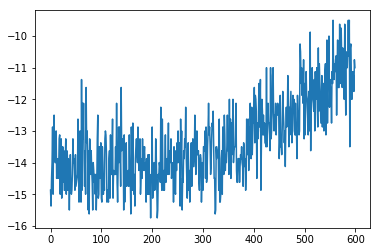 | 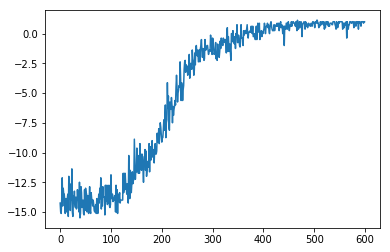 |

### Goal of Policy Gradients

Unlike algorithms such as DQN, which strive to find an excellent policy indirectly through Q-values, policy gradients perform a direct gradient update on a policy to change its parameters, which is what makes it so appealing.

Given a trajectory $\tau$ of length $T$ where $\tau$ is defined as $\tau=\left(s_0,a_0,r_0,s_1,a_1,r_1,\cdots,s_{T−1},a_{T−1},r_{T−1},s_T\right)$. The initial state $s_0$ comes from the starting distribution of states, $a_i\sim\pi_\theta(a_i|s_i)$, and $s_i\sim P(s_i|s_{i−1},a_{i−1})$ with $P$ being the transition dynamics of the environment. We define the discounted reward of the trajectory $R(\tau)=\displaystyle\sum_{t=0}^{T-1}\gamma^tr_t$. The objective of any policy gradient method is then $$\arg\max_\theta \mathbb{E}_{\tau\sim\pi_\theta}{\large[}R(\tau){\large]}$$
$\tau\sim\pi_\theta$ under the expectation means the rewards are computed from a trajectory $\tau$ which was sampled from the policy $\pi_\theta$.


**Notes**:
1. Alternatives include ignoring $\gamma$ by setting it to $1$, extending $T$ to $\infty$ if the episodes are infinite-horizon, and so on.
2. We don't need to optimize the expected sum of discounted rewards here, rather we try to optimize $\theta$.
3. Vanilla policy gradient methods are so **noisy** because we're **not** maximizing the some objective function ( say $f$) of the parameter $\theta$ i.e. $\displaystyle\arg\max_\theta f(\theta)$. We're rather maximizing a function (say $g$) of a random sample drawn from $f(\theta)$ i.e. $\displaystyle\arg\max_\theta g(x)$ where, $x\sim f(\theta)$. So, it's sort of *indirect optimization*.


---

Next: [Actor Critic Methods](./Actor%20Critic%20Methods.ipynb)